# Data configuration

In [9]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from pathlib import Path
from collections import Counter, OrderedDict

In [10]:
# 프로젝트 루트 탐색

# 한 번만 찾고 고정
def find_project_root(marker_filename=".project-root"):
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if os.path.isfile(os.path.join(current_dir, marker_filename)):
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:
            raise FileNotFoundError(f"Could not find {marker_filename} in any parent directory.")
        current_dir = parent_dir
        
# 경로/출력 폴더 생성(find_project_root() 호출 후 사용)
def ensure_dir(path):
    # 디렉토리 없으면 생성
    os.makedirs(path, exist_ok=True)

PROJECT_ROOT = find_project_root()
def get_project_path(*paths):
    return os.path.join(PROJECT_ROOT, *paths)

In [11]:
# 파일 루트 지정
coco_path = get_project_path("data", "TomatOD_COCO_3")
train_path = os.path.join(coco_path, "train")
val_path = os.path.join(coco_path, "val")
test_path = os.path.join(coco_path, "test")

# 클래스 순서 정의 (fully-ripe, semi-ripe, unripe 순서)
class_order = ['fully-ripe', 'semi-ripe', 'unripe']
class_colors = ['#D0021B', '#F8E71C', '#7ED321']  # 원본 TomatOD 색상

In [5]:
# 이미지 파일 & COCO 어노테이션 동시 수집

all_image_files = []
split_file_counts = {}

all_images = []
all_annotations = []
all_categories = []

splits = {
    'train': train_path,
    'val': val_path,
    'test': test_path
}

# 각 split에서 이미지 파일과 어노테이션 동시 수집
for split_name, split_path in splits.items():
    split_files = []
    
    # 1. 이미지 파일 수집
    # 루트 디렉토리의 이미지들
  
    # images 폴더의 이미지들
    images_dir = os.path.join(split_path, "images")
    if os.path.exists(images_dir):
        dir_images = [f for f in os.listdir(images_dir) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        dir_paths = [os.path.join(images_dir, f) for f in dir_images]
        split_files.extend(dir_paths)
        all_image_files.extend(dir_paths)
    
    split_file_counts[split_name] = len(split_files)
    
    # 2. COCO 어노테이션 수집 (같은 루프에서)
    json_file = os.path.join(split_path, f"custom_{split_name}.json")
    
    if os.path.exists(json_file):
        try:
            with open(json_file, 'r') as f:
                coco_data = json.load(f)
            
            # 데이터 수집
            for img in coco_data['images']:
                img['split'] = split_name
                all_images.append(img)
            
            for ann in coco_data['annotations']:
                ann['split'] = split_name
                all_annotations.append(ann)
            
            if not all_categories:  # 카테고리는 한 번만 저장
                all_categories = coco_data['categories']
        except Exception as e:
            print(f"{split_name}: 이미지 파일 {len(split_files)}개, JSON 읽기 오류 - {e}")
    else:
        print(f"{split_name}: 이미지 파일 {len(split_files)}개, JSON 파일 없음")

## 3class: Image & Annotation

In [6]:
# === 데이터 분석 ===
split_counts = {'train': 0, 'val': 0, 'test': 0, 'unknown': 0}

# 분석
file_sizes = []
resolutions = []
formats = []
channels = []
resolution_details = {}  # 해상도별 상세 정보
file_paths_by_resolution = {}  # 해상도별 파일 경로

processed = 0
errors = 0
error_files = []

for i, img_path in enumerate(all_image_files):
    try:
        # 파일 크기
        file_size = os.path.getsize(img_path) / (1024 * 1024)  # MB
        file_sizes.append(file_size)

        # === (추가) split 카운트 ===
        split_name_found = None
        for split_name in ['train', 'val', 'test']:
            if split_name in img_path:
                split_counts[split_name] += 1
                split_name_found = split_name
                break
        if split_name_found is None:
            split_counts['unknown'] += 1

        # 이미지 속성
        with Image.open(img_path) as img:
            width, height = img.size
            resolution = (width, height)
            resolutions.append(resolution)

            # 해상도별 상세 정보 수집
            if resolution not in resolution_details:
                resolution_details[resolution] = {
                    'count': 0,
                    'files': [],
                    'splits': {'train': 0, 'val': 0, 'test': 0}
                }

            resolution_details[resolution]['count'] += 1
            resolution_details[resolution]['files'].append(img_path)

            # 어느 split에 속하는지 확인 (기존 로직 유지)
            for split_name in ['train', 'val', 'test']:
                if split_name in img_path:
                    resolution_details[resolution]['splits'][split_name] += 1
                    break

            # 파일 형식
            formats.append(img.format)

            # 색상 채널
            mode = img.mode
            if mode == 'RGB':
                channels.append(3)
            elif mode == 'RGBA':
                channels.append(4)
            elif mode == 'L':
                channels.append(1)
            else:
                channels.append(len(img.getbands()))

        processed += 1

    except Exception as e:
        errors += 1
        error_files.append((img_path, str(e)))
        if errors <= 5:  # 처음 5개 오류만 출력
            print(f"  오류 ({os.path.basename(img_path)}): {e}")

In [7]:
# === 결과 정리 ===
print(f"\n" + "="*40)
print("전체 데이터셋 이미지 분석 결과")
print("="*40)

# 기본 통계
print(f"\n기본 통계:")
print(f"  - 총 이미지 파일: {len(all_image_files)}개")
print(f"  - 성공적으로 분석된 파일: {processed}개")

if split_file_counts:
    total = sum(split_file_counts.values())
    print(f"\nSplit별 분포:")
    for split_name, count in split_file_counts.items():
        percentage = (count / total * 100) if total > 0 else 0
        print(f"  - {split_name}: {count}개 ({percentage:.1f}%)")

# 해상도 분석
print(f"\n해상도:")
if resolutions:
    unique_resolutions = list(set(resolutions))    
    # 해상도별 상세 분석
    for resolution in sorted(unique_resolutions, key=lambda x: x[0]*x[1], reverse=True):
        count = resolution_details[resolution]['count']
        percentage = (count / len(resolutions) * 100)
        print(f"  {resolution[0]}×{resolution[1]}:")
        print(f"    - 파일 수: {count}개 ({percentage:.1f}%)")

# 파일 형식 분석
if formats:
    unique_formats = list(set(formats))
    format_counts = Counter(formats)
    for fmt, count in format_counts.items():
        percentage = (count / len(formats) * 100)
        print(f"\n파일 형식 {fmt}: {count}개")

# 색상 채널 분석
if channels:
    unique_channels = list(set(channels))
    channel_counts = Counter(channels)
    for ch, count in channel_counts.items():
        percentage = (count / len(channels) * 100)
        if ch == 1:
            desc = "Grayscale"
        elif ch == 3:
            desc = "RGB"
        elif ch == 4:
            desc = "RGBA"
        else:
            desc = f"{ch}-channel"
        print(f"\n색상 채널:{desc}")


from math import gcd
from functools import reduce

t = split_counts['train']
v = split_counts['val']
te = split_counts['test']

if te > 0:
    r_train = round(t / te)
    r_val   = round(v / te)
    r_test  = 1

    print("\nRounded split ratio")
    print(f"  train : val : test ≈ {r_train}:{r_val}:{r_test}")
else:
    print("\nRounded split ratio")
    print("  test split이 0이라 비율 계산 불가")


전체 데이터셋 이미지 분석 결과

기본 통계:
  - 총 이미지 파일: 277개
  - 성공적으로 분석된 파일: 277개

Split별 분포:
  - train: 193개 (69.7%)
  - val: 54개 (19.5%)
  - test: 30개 (10.8%)

해상도:
  2000×2000:
    - 파일 수: 277개 (100.0%)

파일 형식 JPEG: 277개

색상 채널:RGB

Rounded split ratio
  train : val : test ≈ 6:2:1


In [8]:
# === 클래스 정보 분석 ===

print(f"\n전체 수집 결과")
print(f"총 이미지: {len(all_images)}개")
print(f"총 어노테이션: {len(all_annotations)}개")
print(f"카테고리: {len(all_categories)}개")

# === 1. 클래스 정보 분석 ===
print(f"\n" + "="*40)
print("1. 클래스 정보 분석")
print("="*40)

# 클래스 수 및 이름
print(f"클래스 수: {len(all_categories)}개")
print(f"\n클래스 명 및 정의:")

category_map = {}
for cat in all_categories:
    category_map[cat['id']] = cat['name']
    print(f"  ID {cat['id']}: {cat['name']}")

# 클래스별 객체 수 계산
class_counts = Counter()
split_class_counts = {split: Counter() for split in splits}

for ann in all_annotations:
    class_name = category_map[ann['category_id']]
    split_name = ann['split']
    
    class_counts[class_name] += 1
    split_class_counts[split_name][class_name] += 1

# 클래스 분포 출력
total_objects = sum(class_counts.values())
print(f"\n클래스별 객체 수 (전체):")
class_order = ['fully-ripe', 'semi-ripe', 'unripe']

for class_name in class_order:
    count = class_counts[class_name]
    percentage = (count / total_objects) * 100
    print(f"  {class_name}: {count}개 ({percentage:.1f}%)")

# Split별 클래스 분포
print(f"\nSplit별 클래스 분포:")
for split_name in splits:
    split_total = sum(split_class_counts[split_name].values())
    if split_total > 0:
        print(f"\n  {split_name} (객체 {split_total}개):")
        for class_name in class_order:
            count = split_class_counts[split_name][class_name]
            percentage = (count / split_total) * 100 if split_total > 0 else 0
            print(f"    {class_name}: {count}개 ({percentage:.1f}%)")


전체 수집 결과
총 이미지: 277개
총 어노테이션: 2797개
카테고리: 3개

1. 클래스 정보 분석
클래스 수: 3개

클래스 명 및 정의:
  ID 0: fully-ripe
  ID 1: semi-ripe
  ID 2: unripe

클래스별 객체 수 (전체):
  fully-ripe: 489개 (17.5%)
  semi-ripe: 437개 (15.6%)
  unripe: 1871개 (66.9%)

Split별 클래스 분포:

  train (객체 1937개):
    fully-ripe: 340개 (17.6%)
    semi-ripe: 286개 (14.8%)
    unripe: 1311개 (67.7%)

  val (객체 581개):
    fully-ripe: 93개 (16.0%)
    semi-ripe: 108개 (18.6%)
    unripe: 380개 (65.4%)

  test (객체 279개):
    fully-ripe: 56개 (20.1%)
    semi-ripe: 43개 (15.4%)
    unripe: 180개 (64.5%)


=== 시각화 데이터 확인 ===
class_counts: {'semi-ripe': 437, 'unripe': 1871, 'fully-ripe': 489}
split_class_counts keys: ['train', 'val', 'test']


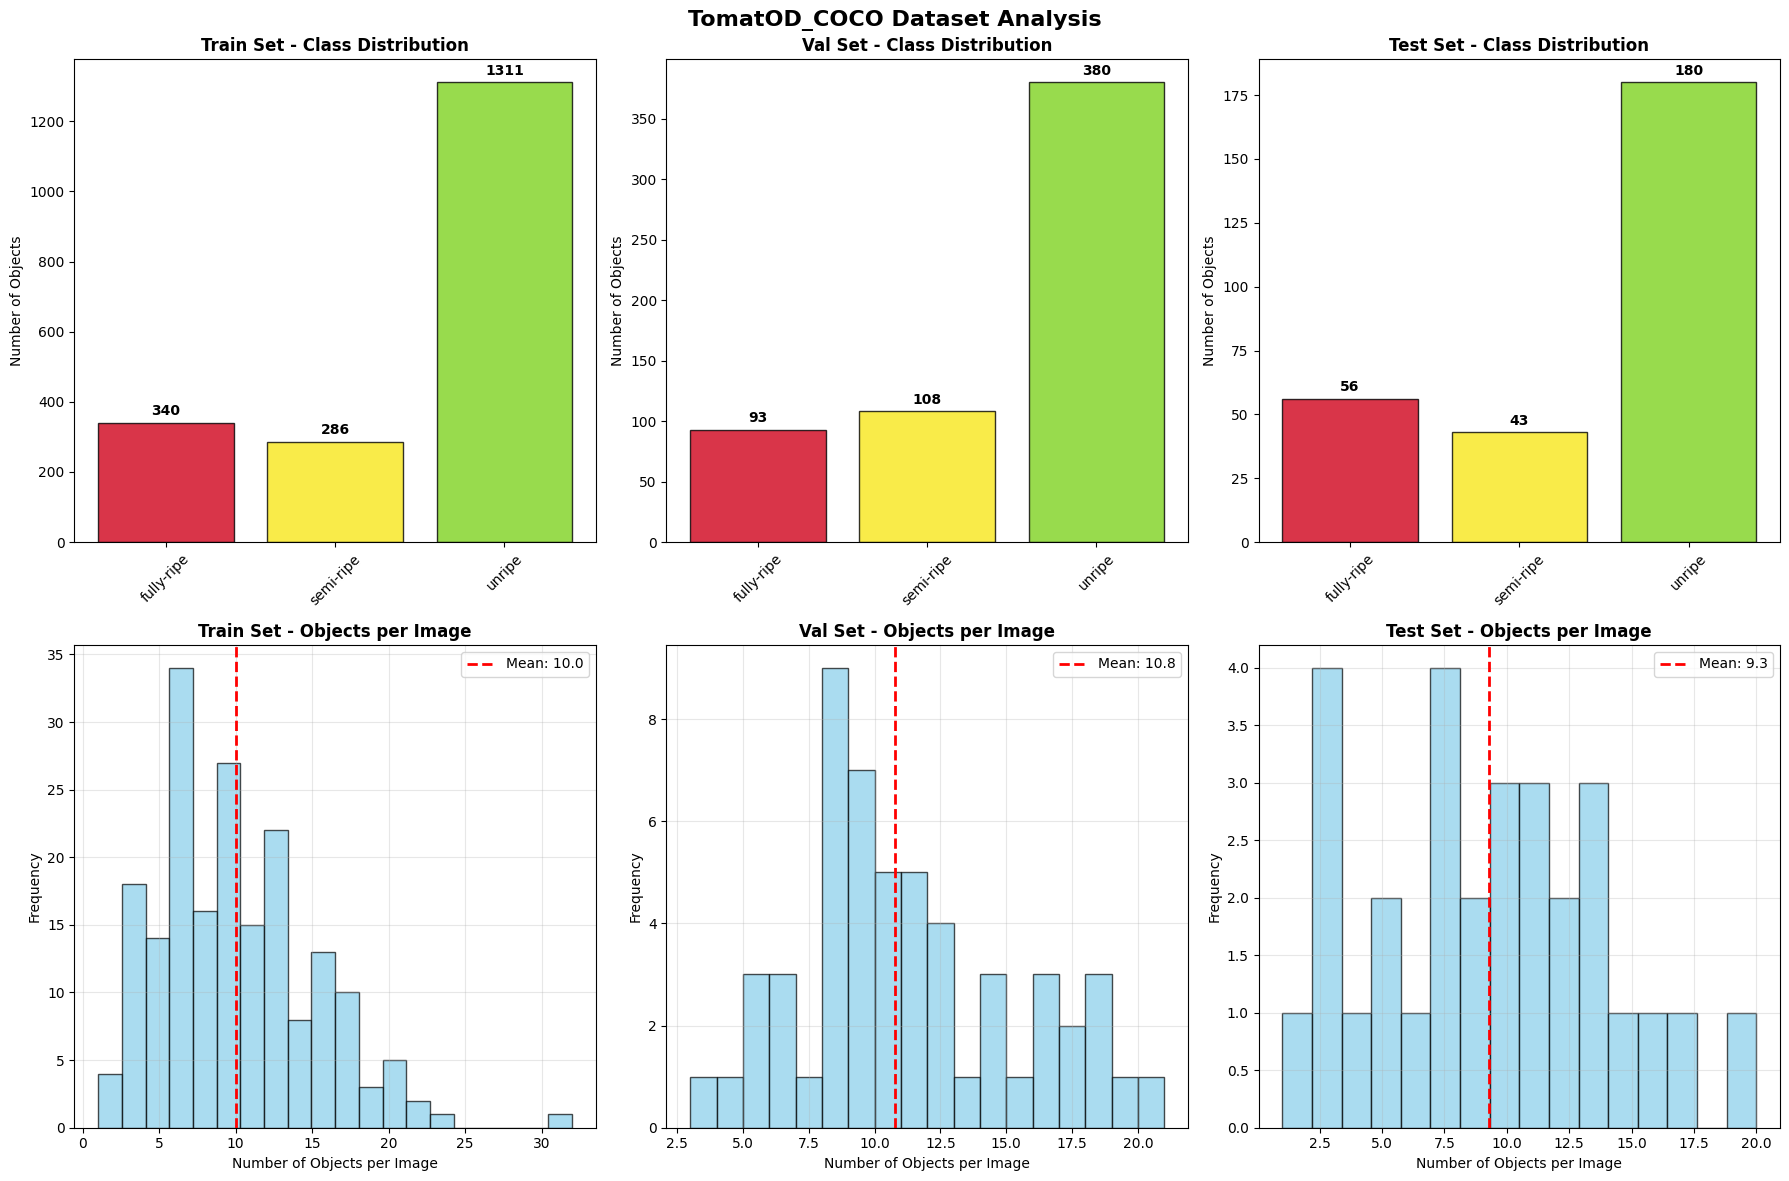

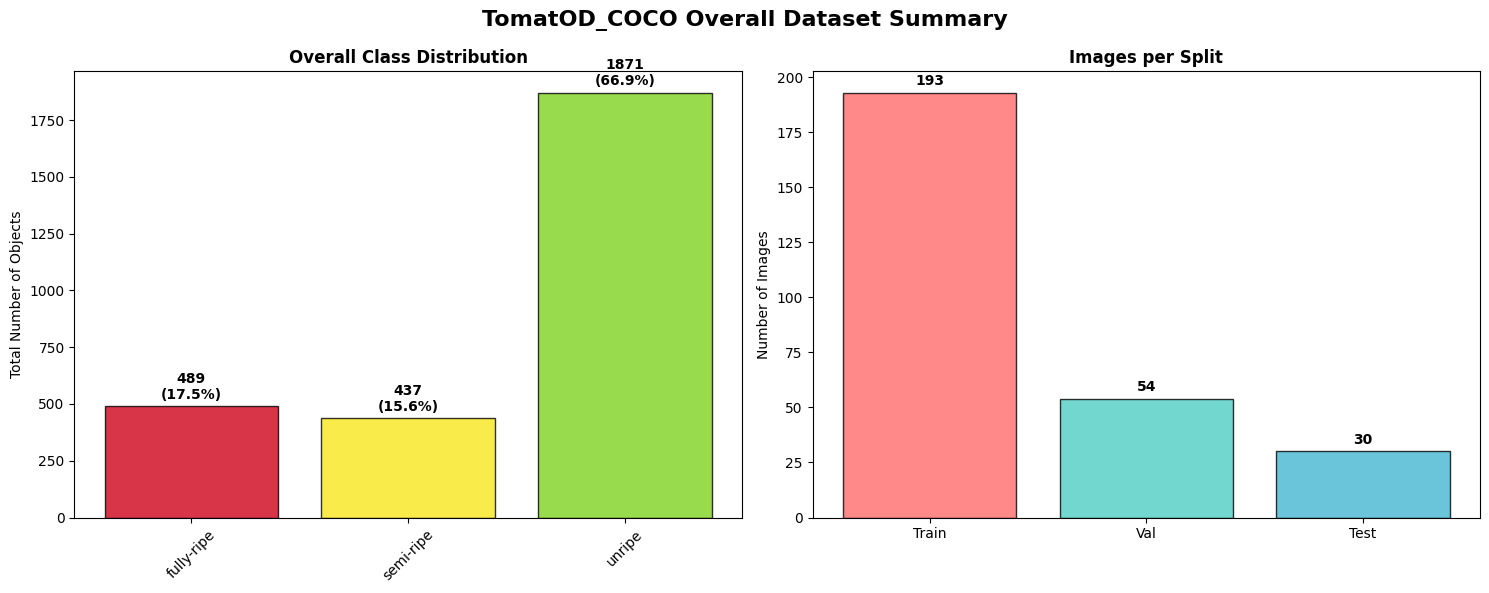


[DONE] 시각화 완료


In [9]:
# === 시각화 ===

import matplotlib.pyplot as plt
import numpy as np

# === 1. split별 통계 준비 (이전 셀에서 정의된 변수 사용) ===

# train_stats, val_stats, test_stats 대신 split_class_counts 사용
# total_class_counts 대신 class_counts 사용

print("=== 시각화 데이터 확인 ===")
print(f"class_counts: {dict(class_counts)}")
print(f"split_class_counts keys: {list(split_class_counts.keys())}")

# === 2. 2x3 서브플롯 생성 ===
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('TomatOD_COCO Dataset Analysis', fontsize=16, fontweight='bold')

# === 3. 각 split의 클래스 분포 ===
splits_data = [
    ('Train', 'train', axes[0, 0]),
    ('Val', 'val', axes[0, 1]), 
    ('Test', 'test', axes[0, 2])
]

for split_label, split_key, ax in splits_data:
    if split_key in split_class_counts and split_class_counts[split_key]:
        classes = []
        counts = []
        colors = []
        
        for i, class_name in enumerate(class_order):
            if class_name in split_class_counts[split_key]:
                classes.append(class_name)
                counts.append(split_class_counts[split_key][class_name])
                colors.append(class_colors[i])
        
        if classes and counts:
            bars = ax.bar(classes, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
            ax.set_title(f'{split_label} Set - Class Distribution', fontweight='bold')
            ax.set_ylabel('Number of Objects')
            ax.tick_params(axis='x', rotation=45)
            
            for bar, count in zip(bars, counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                       f'{count}', ha='center', va='bottom', fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{split_label} Set - No Data')
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{split_label} Set - No Data')

# === 4. 각 split의 이미지당 객체 수 분포 ===
# split별 objects_per_image 계산
split_objects_per_image = {}
for split_name in ['train', 'val', 'test']:
    split_anns = [ann for ann in all_annotations if ann.get('split') == split_name]
    img_counts = Counter()
    for ann in split_anns:
        img_counts[ann['image_id']] += 1
    split_objects_per_image[split_name] = list(img_counts.values()) if img_counts else []

splits_hist_data = [
    ('Train', 'train', axes[1, 0]),
    ('Val', 'val', axes[1, 1]),
    ('Test', 'test', axes[1, 2])
]

for split_label, split_key, ax in splits_hist_data:
    objs = split_objects_per_image.get(split_key, [])
    if objs:
        ax.hist(objs, bins=min(20, len(set(objs))), 
               alpha=0.7, color='skyblue', edgecolor='black', linewidth=1)
        ax.set_title(f'{split_label} Set - Objects per Image', fontweight='bold')
        ax.set_xlabel('Number of Objects per Image')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
        
        mean_obj = np.mean(objs)
        ax.axvline(mean_obj, color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {mean_obj:.1f}')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{split_label} Set - No Data')

plt.tight_layout()
plt.show()

# === 5. 전체 데이터셋 요약 차트 ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('TomatOD_COCO Overall Dataset Summary', fontsize=16, fontweight='bold')

# 전체 클래스 분포 (class_counts 사용)
classes = []
counts = []
colors_for_total = []

for i, class_name in enumerate(class_order):
    if class_name in class_counts:
        classes.append(class_name)
        counts.append(class_counts[class_name])
        colors_for_total.append(class_colors[i])

bars1 = ax1.bar(classes, counts, color=colors_for_total, alpha=0.8, 
               edgecolor='black', linewidth=1)
ax1.set_title('Overall Class Distribution', fontweight='bold')
ax1.set_ylabel('Total Number of Objects')
ax1.tick_params(axis='x', rotation=45)

total_objs = sum(counts)
for bar, count in zip(bars1, counts):
    height = bar.get_height()
    percentage = (count / total_objs) * 100 if total_objs > 0 else 0
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
            f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Split별 이미지 수 비교 (split_file_counts 사용)
split_names = []
split_img_counts = []
split_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for split_name in ['train', 'val', 'test']:
    if split_name in split_file_counts:
        split_names.append(split_name.capitalize())
        split_img_counts.append(split_file_counts[split_name])

if split_names and split_img_counts:
    bars2 = ax2.bar(split_names, split_img_counts, color=split_colors[:len(split_names)], 
                   alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_title('Images per Split', fontweight='bold')
    ax2.set_ylabel('Number of Images')
    
    for bar, count in zip(bars2, split_img_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(split_img_counts)*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n[DONE] 시각화 완료")

In [10]:
# === 바운딩 박스 통계 ===

print(f"\n" + "="*60)
print("2. 바운딩 박스 통계")
print("="*60)

# 총 어노테이션 수
print(f"총 어노테이션 수: {len(all_annotations)}개")

# 이미지당 객체 수 계산
image_object_counts = Counter()
for ann in all_annotations:
    image_object_counts[ann['image_id']] += 1

objects_per_image = list(image_object_counts.values())

print(f"\n이미지당 객체 수 통계:")
print(f"  평균: {np.mean(objects_per_image):.2f}개")
print(f"  중간값: {np.median(objects_per_image):.2f}개")
print(f"  최소: {np.min(objects_per_image)}개")
print(f"  최대: {np.max(objects_per_image)}개")
print(f"  표준편차: {np.std(objects_per_image):.2f}")

# 이미지당 객체 수 분포
unique_counts = Counter(objects_per_image)
print(f"\n이미지당 객체 수 분포:")
for obj_count in sorted(unique_counts.keys()):
    img_count = unique_counts[obj_count]
    percentage = (img_count / len(objects_per_image)) * 100
    print(f"  {obj_count}개 객체: {img_count}개 이미지 ({percentage:.1f}%)")

# 바운딩 박스 크기 분석
bbox_areas = []
bbox_widths = []
bbox_heights = []
bbox_aspect_ratios = []
bbox_centers_x = []
bbox_centers_y = []

for ann in all_annotations:
    bbox = ann['bbox']  # [x, y, width, height]
    x, y, w, h = bbox
    
    area = w * h
    aspect_ratio = w / h if h > 0 else 0
    center_x = x + w / 2
    center_y = y + h / 2
    
    bbox_areas.append(area)
    bbox_widths.append(w)
    bbox_heights.append(h)
    bbox_aspect_ratios.append(aspect_ratio)
    bbox_centers_x.append(center_x)
    bbox_centers_y.append(center_y)

print(f"\n바운딩 박스 면적 통계:")
print(f"  평균: {np.mean(bbox_areas):.2f} 픽셀²")
print(f"  중간값: {np.median(bbox_areas):.2f} 픽셀²")
print(f"  최소: {np.min(bbox_areas):.2f} 픽셀²")
print(f"  최대: {np.max(bbox_areas):.2f} 픽셀²")
print(f"  표준편차: {np.std(bbox_areas):.2f}")

print(f"\n바운딩 박스 크기 통계:")
print(f"  너비 - 평균: {np.mean(bbox_widths):.2f}, 범위: {np.min(bbox_widths):.2f}~{np.max(bbox_widths):.2f}")
print(f"  높이 - 평균: {np.mean(bbox_heights):.2f}, 범위: {np.min(bbox_heights):.2f}~{np.max(bbox_heights):.2f}")

print(f"\n너비/높이 비율 통계:")
print(f"  평균 비율: {np.mean(bbox_aspect_ratios):.2f}")
print(f"  중간값 비율: {np.median(bbox_aspect_ratios):.2f}")
print(f"  비율 범위: {np.min(bbox_aspect_ratios):.2f}~{np.max(bbox_aspect_ratios):.2f}")

# 객체 크기 분류 (작은/중간/큰)
area_percentiles = np.percentile(bbox_areas, [33, 67])
small_threshold = area_percentiles[0]
large_threshold = area_percentiles[1]

small_objects = sum(1 for area in bbox_areas if area <= small_threshold)
medium_objects = sum(1 for area in bbox_areas if small_threshold < area <= large_threshold)
large_objects = sum(1 for area in bbox_areas if area > large_threshold)

total_objects = len(bbox_areas)
print(f"\n객체 크기 분류 (면적 기준):")
print(f"  작은 객체 (≤{small_threshold:.0f}): {small_objects}개 ({small_objects/total_objects*100:.1f}%)")
print(f"  중간 객체 ({small_threshold:.0f}~{large_threshold:.0f}): {medium_objects}개 ({medium_objects/total_objects*100:.1f}%)")
print(f"  큰 객체 (>{large_threshold:.0f}): {large_objects}개 ({large_objects/total_objects*100:.1f}%)")

# 객체 위치 분포 분석 (이미지 크기 2000x2000 기준)
image_width = 2000
image_height = 2000

# 정규화된 중심점 좌표 (0~1 범위)
normalized_centers_x = [x / image_width for x in bbox_centers_x]
normalized_centers_y = [y / image_height for y in bbox_centers_y]

print(f"\n객체 위치 분포 (정규화된 좌표):")
print(f"  중심점 X - 평균: {np.mean(normalized_centers_x):.3f}, 표준편차: {np.std(normalized_centers_x):.3f}")
print(f"  중심점 Y - 평균: {np.mean(normalized_centers_y):.3f}, 표준편차: {np.std(normalized_centers_y):.3f}")

# 이미지 영역별 객체 분포 (9개 영역으로 분할)
regions = {
    'top-left': 0, 'top-center': 0, 'top-right': 0,
    'middle-left': 0, 'middle-center': 0, 'middle-right': 0,
    'bottom-left': 0, 'bottom-center': 0, 'bottom-right': 0
}

for norm_x, norm_y in zip(normalized_centers_x, normalized_centers_y):
    # X 방향 영역 결정
    if norm_x < 0.33:
        x_region = 'left'
    elif norm_x < 0.67:
        x_region = 'center'
    else:
        x_region = 'right'
    
    # Y 방향 영역 결정
    if norm_y < 0.33:
        y_region = 'top'
    elif norm_y < 0.67:
        y_region = 'middle'
    else:
        y_region = 'bottom'
    
    region_key = f"{y_region}-{x_region}"
    regions[region_key] += 1

print(f"\n이미지 영역별 객체 분포:")
region_order = [
    'top-left', 'top-center', 'top-right',
    'middle-left', 'middle-center', 'middle-right',
    'bottom-left', 'bottom-center', 'bottom-right'
]

for i, region in enumerate(region_order):
    count = regions[region]
    percentage = (count / total_objects) * 100
    print(f"  {region}: {count}개 ({percentage:.1f}%)")
    
    # 3x3 그리드로 출력
    if (i + 1) % 3 == 0:
        print()


2. 바운딩 박스 통계
총 어노테이션 수: 2797개

이미지당 객체 수 통계:
  평균: 14.49개
  중간값: 12.00개
  최소: 1개
  최대: 45개
  표준편차: 8.92

이미지당 객체 수 분포:
  1개 객체: 1개 이미지 (0.5%)
  3개 객체: 4개 이미지 (2.1%)
  4개 객체: 10개 이미지 (5.2%)
  5개 객체: 9개 이미지 (4.7%)
  6개 객체: 6개 이미지 (3.1%)
  7개 객체: 17개 이미지 (8.8%)
  8개 객체: 12개 이미지 (6.2%)
  9개 객체: 11개 이미지 (5.7%)
  10개 객체: 10개 이미지 (5.2%)
  11개 객체: 9개 이미지 (4.7%)
  12개 객체: 12개 이미지 (6.2%)
  13개 객체: 8개 이미지 (4.1%)
  14개 객체: 6개 이미지 (3.1%)
  15개 객체: 10개 이미지 (5.2%)
  16개 객체: 6개 이미지 (3.1%)
  17개 객체: 7개 이미지 (3.6%)
  18개 객체: 5개 이미지 (2.6%)
  19개 객체: 3개 이미지 (1.6%)
  20개 객체: 3개 이미지 (1.6%)
  21개 객체: 5개 이미지 (2.6%)
  22개 객체: 4개 이미지 (2.1%)
  23개 객체: 2개 이미지 (1.0%)
  24개 객체: 4개 이미지 (2.1%)
  25개 객체: 2개 이미지 (1.0%)
  26개 객체: 1개 이미지 (0.5%)
  28개 객체: 4개 이미지 (2.1%)
  29개 객체: 5개 이미지 (2.6%)
  30개 객체: 4개 이미지 (2.1%)
  31개 객체: 2개 이미지 (1.0%)
  32개 객체: 3개 이미지 (1.6%)
  33개 객체: 2개 이미지 (1.0%)
  37개 객체: 2개 이미지 (1.0%)
  38개 객체: 2개 이미지 (1.0%)
  39개 객체: 1개 이미지 (0.5%)
  45개 객체: 1개 이미지 (0.5%)

바운딩 박스 면적 통계:
  평균: 12668.32 픽셀²
  중간값: 

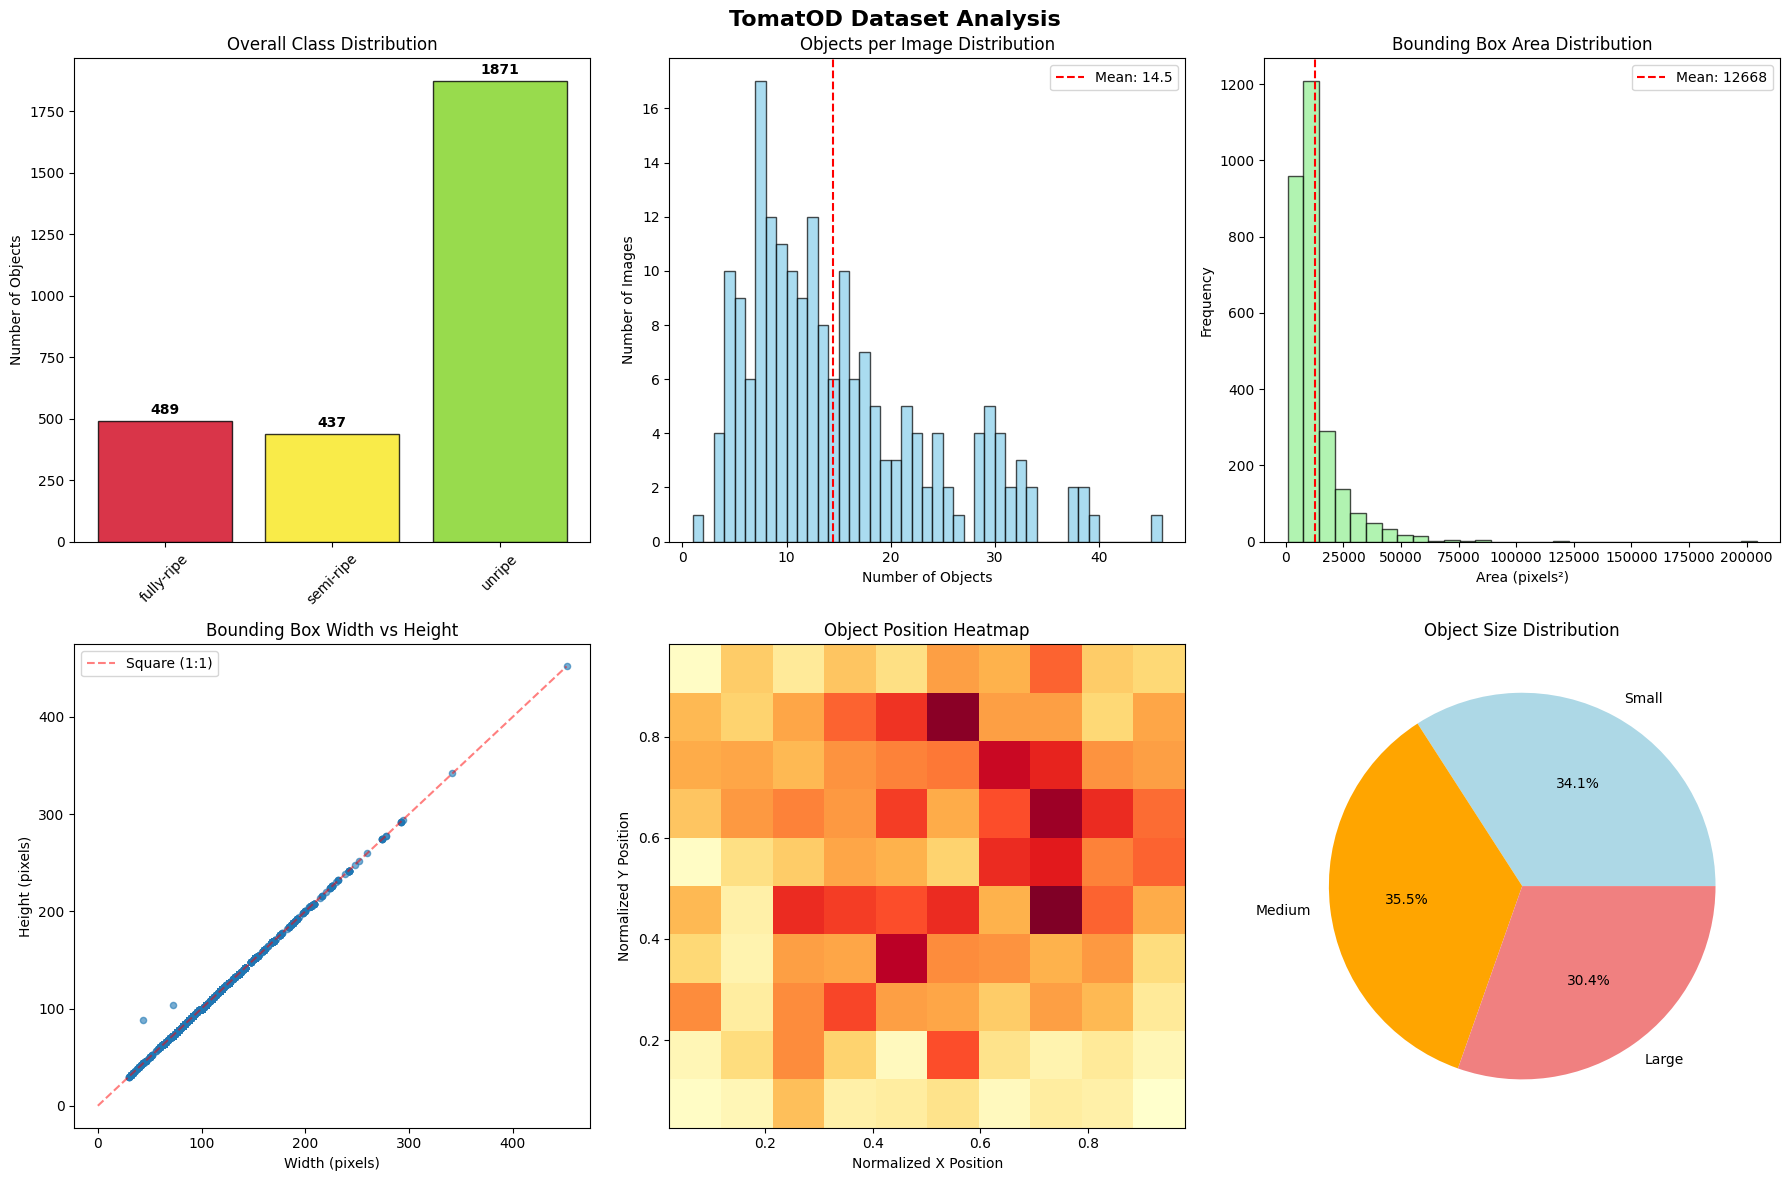

In [11]:
# === 시각화 ===
# 1. 클래스 분포 차트
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('TomatOD Dataset Analysis', fontsize=16, fontweight='bold')

# 전체 클래스 분포
class_names = [class_counts[name] for name in class_order]
colors = ['#D0021B', '#F8E71C', '#7ED321']

axes[0, 0].bar(class_order, class_names, color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Overall Class Distribution')
axes[0, 0].set_ylabel('Number of Objects')
axes[0, 0].tick_params(axis='x', rotation=45)

# 막대 위에 숫자 표시
for i, (name, count) in enumerate(zip(class_order, class_names)):
    axes[0, 0].text(i, count + max(class_names)*0.01, str(count), 
                   ha='center', va='bottom', fontweight='bold')

# 이미지당 객체 수 분포
axes[0, 1].hist(objects_per_image, bins=range(1, max(objects_per_image)+2), 
               alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Objects per Image Distribution')
axes[0, 1].set_xlabel('Number of Objects')
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].axvline(np.mean(objects_per_image), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(objects_per_image):.1f}')
axes[0, 1].legend()

# 바운딩 박스 면적 분포
axes[0, 2].hist(bbox_areas, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Bounding Box Area Distribution')
axes[0, 2].set_xlabel('Area (pixels²)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(np.mean(bbox_areas), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(bbox_areas):.0f}')
axes[0, 2].legend()

# 너비 vs 높이 산점도
axes[1, 0].scatter(bbox_widths, bbox_heights, alpha=0.6, s=20)
axes[1, 0].set_title('Bounding Box Width vs Height')
axes[1, 0].set_xlabel('Width (pixels)')
axes[1, 0].set_ylabel('Height (pixels)')
axes[1, 0].plot([0, max(max(bbox_widths), max(bbox_heights))], 
               [0, max(max(bbox_widths), max(bbox_heights))], 
               'r--', alpha=0.5, label='Square (1:1)')
axes[1, 0].legend()

# 객체 위치 히트맵
axes[1, 1].hist2d(normalized_centers_x, normalized_centers_y, bins=10, cmap='YlOrRd')
axes[1, 1].set_title('Object Position Heatmap')
axes[1, 1].set_xlabel('Normalized X Position')
axes[1, 1].set_ylabel('Normalized Y Position')

# 크기별 객체 분포
size_labels = ['Small', 'Medium', 'Large']
size_counts = [small_objects, medium_objects, large_objects]
size_colors = ['lightblue', 'orange', 'lightcoral']

axes[1, 2].pie(size_counts, labels=size_labels, colors=size_colors, autopct='%1.1f%%')
axes[1, 2].set_title('Object Size Distribution')

plt.tight_layout()

plt.show()

# 1class: Inage & Annotation

In [12]:
SOURCE_ROOT = get_project_path("data", "TomatOD_COCO_3")
TARGET_ROOT = get_project_path("data", "TomatOD_COCO_1")

# 원본 구조 확인
for split in ['train', 'val', 'test']:
    split_path = os.path.join(SOURCE_ROOT, split, 'images')
    if os.path.exists(split_path):
        files = os.listdir(split_path)
        jpg_count = len([f for f in files if f.endswith('.jpg')])
        json_count = len([f for f in files if f.endswith('.json')])
        print(f"  {split}/: 이미지 {jpg_count}개, JSON {json_count}개")

  train/: 이미지 193개, JSON 0개
  val/: 이미지 54개, JSON 0개
  test/: 이미지 30개, JSON 0개


In [13]:
# === 원본 annotation 샘플 확인 ===
sample_json_path = os.path.join(SOURCE_ROOT, "train", "custom_train.json")

print("=== Original train data annotation ===")
with open(sample_json_path, 'r') as f:
    sample_data = json.load(f)

print(f"\n카테고리 (원본 3 클래스):")
for cat in sample_data['categories']:
    print(f"  ID {cat['id']}: {cat['name']}")

print(f"\n이미지 수: {len(sample_data['images'])}")
print(f"어노테이션 수: {len(sample_data['annotations'])}")

# 첫 번째 어노테이션 샘플
print(f"\n첫 번째 어노테이션 샘플:")
print(json.dumps(sample_data['annotations'][0], indent=2))

=== Original train data annotation ===

카테고리 (원본 3 클래스):
  ID 0: fully-ripe
  ID 1: semi-ripe
  ID 2: unripe

이미지 수: 193
어노테이션 수: 1937

첫 번째 어노테이션 샘플:
{
  "id": 1,
  "image_id": 1,
  "category_id": 1,
  "bbox": [
    1245,
    218,
    154,
    154
  ],
  "area": 23716,
  "iscrowd": 0
}


In [14]:
# === 대상 폴더 생성 ===
print("=== 폴더 생성 및 이미지 복사 ===")

for split in ['train', 'val', 'test']:
    # 대상 폴더 생성
    target_split_path = os.path.join(TARGET_ROOT, split)
    os.makedirs(target_split_path, exist_ok=True)
    print(f"\n{split}/ 폴더 생성: {target_split_path}")
    
    # 이미지 복사
    source_split_path = os.path.join(SOURCE_ROOT, split)
    
    # images 폴더가 있는 경우
    source_images_dir = os.path.join(source_split_path, "images")
    target_images_dir = os.path.join(target_split_path, "images")
    
    if os.path.exists(source_images_dir):
        os.makedirs(target_images_dir, exist_ok=True)
        image_files = [f for f in os.listdir(source_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_file in image_files:
            src = os.path.join(source_images_dir, img_file)
            dst = os.path.join(target_images_dir, img_file)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)
        
        print(f"  images/ 복사: {len(image_files)}개")
    
    # 루트에 이미지가 있는 경우
    root_images = [f for f in os.listdir(source_split_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if root_images:
        for img_file in root_images:
            src = os.path.join(source_split_path, img_file)
            dst = os.path.join(target_split_path, img_file)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)
        print(f"  루트 이미지 복사: {len(root_images)}개")

print("\n[DONE] 이미지 복사 완료")

=== 폴더 생성 및 이미지 복사 ===

train/ 폴더 생성: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_COCO_1/train
  images/ 복사: 193개

val/ 폴더 생성: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_COCO_1/val
  images/ 복사: 54개

test/ 폴더 생성: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_COCO_1/test
  images/ 복사: 30개

[DONE] 이미지 복사 완료


In [15]:
# === Annotation 변환: 3 클래스 → 1 클래스 ===
print("=== Annotation 변환 (3 class → 1 class) ===")

# 새로운 단일 카테고리 정의
NEW_CATEGORY = [{"id": 0, "name": "tomato"}]

for split in ['train', 'val', 'test']:
    source_json = os.path.join(SOURCE_ROOT, split, f"custom_{split}.json")
    target_json = os.path.join(TARGET_ROOT, split, f"custom_{split}.json")
    
    print(f"\n--- {split} 처리 ---")
    print(f"원본: {source_json}")
    print(f"대상: {target_json}")
    
    # 원본 JSON 로드
    if not os.path.exists(source_json):
        print(f"  [WARNING] 원본 JSON 없음, 스킵")
        continue
    
    with open(source_json, 'r') as f:
        data = json.load(f)
    
    # 디버깅: 변환 전 상태
    print(f"\n  [변환 전]")
    print(f"  - 이미지: {len(data['images'])}개")
    print(f"  - 어노테이션: {len(data['annotations'])}개")
    print(f"  - 카테고리: {len(data['categories'])}개")
    
    original_categories = {cat['id']: cat['name'] for cat in data['categories']}
    print(f"  - 원본 카테고리: {original_categories}")
    
    # 카테고리별 어노테이션 수 (변환 전)
    cat_counts_before = {}
    for ann in data['annotations']:
        cat_id = ann['category_id']
        cat_name = original_categories.get(cat_id, f"unknown_{cat_id}")
        cat_counts_before[cat_name] = cat_counts_before.get(cat_name, 0) + 1
    print(f"  - 클래스별 객체 수: {cat_counts_before}")
    
    # === 변환 수행 ===
    # 1. 카테고리를 단일 클래스로 변경
    data['categories'] = NEW_CATEGORY
    
    # 2. 모든 어노테이션의 category_id를 0으로 변경
    for ann in data['annotations']:
        ann['category_id'] = 0
    
    # 디버깅: 변환 후 상태
    print(f"\n  [변환 후]")
    print(f"  - 이미지: {len(data['images'])}개")
    print(f"  - 어노테이션: {len(data['annotations'])}개")
    print(f"  - 카테고리: {data['categories']}")
    
    # 카테고리별 어노테이션 수 (변환 후)
    cat_counts_after = {}
    for ann in data['annotations']:
        cat_id = ann['category_id']
        cat_counts_after[cat_id] = cat_counts_after.get(cat_id, 0) + 1
    print(f"  - 클래스별 객체 수: {cat_counts_after}")
    
    # 저장
    with open(target_json, 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"  [SAVED] {target_json}")

print("\n[DONE] Annotation 변환 완료")

=== Annotation 변환 (3 class → 1 class) ===

--- train 처리 ---
원본: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_COCO_3/train/custom_train.json
대상: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_COCO_1/train/custom_train.json

  [변환 전]
  - 이미지: 193개
  - 어노테이션: 1937개
  - 카테고리: 3개
  - 원본 카테고리: {0: 'fully-ripe', 1: 'semi-ripe', 2: 'unripe'}
  - 클래스별 객체 수: {'semi-ripe': 286, 'unripe': 1311, 'fully-ripe': 340}

  [변환 후]
  - 이미지: 193개
  - 어노테이션: 1937개
  - 카테고리: [{'id': 0, 'name': 'tomato'}]
  - 클래스별 객체 수: {0: 1937}
  [SAVED] /home/hyeonjin/tomato-detection-agentic/data/TomatOD_COCO_1/train/custom_train.json

--- val 처리 ---
원본: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_COCO_3/val/custom_val.json
대상: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_COCO_1/val/custom_val.json

  [변환 전]
  - 이미지: 54개
  - 어노테이션: 581개
  - 카테고리: 3개
  - 원본 카테고리: {0: 'fully-ripe', 1: 'semi-ripe', 2: 'unripe'}
  - 클래스별 객체 수: {'semi-ripe': 108, 'unripe': 380, 'fully-ripe': 93}

  [변환 후]
  - 이미지:

In [16]:
# === 결과 검증 ===
print("=== 결과 검증 ===")

for split in ['train', 'val', 'test']:
    target_json = os.path.join(TARGET_ROOT, split, f"custom_{split}.json")
    
    print(f"\n--- {split} 검증 ---")
    
    if not os.path.exists(target_json):
        print(f"  [ERROR] JSON 파일 없음")
        continue
    
    with open(target_json, 'r') as f:
        data = json.load(f)
    
    # 카테고리 확인
    print(f"  카테고리: {data['categories']}")
    
    # 모든 category_id가 0인지 확인
    unique_cat_ids = set(ann['category_id'] for ann in data['annotations'])
    print(f"  사용된 category_id: {unique_cat_ids}")
    
    if unique_cat_ids == {0}:
        print(f"  [OK] 모든 어노테이션이 단일 클래스(0)로 변환됨")
    else:
        print(f"  [WARNING] 변환되지 않은 category_id 존재!")
    
    # 이미지 파일 존재 확인
    target_split_path = os.path.join(TARGET_ROOT, split)
    
    # images 폴더 확인
    images_dir = os.path.join(target_split_path, "images")
    if os.path.exists(images_dir):
        img_count = len([f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  images/ 폴더 이미지: {img_count}개")
    
    # 루트 이미지 확인
    root_imgs = [f for f in os.listdir(target_split_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if root_imgs:
        print(f"  루트 이미지: {len(root_imgs)}개")
    
    print(f"  JSON 이미지 수: {len(data['images'])}개")
    print(f"  JSON 어노테이션 수: {len(data['annotations'])}개")


=== 결과 검증 ===

--- train 검증 ---
  카테고리: [{'id': 0, 'name': 'tomato'}]
  사용된 category_id: {0}
  [OK] 모든 어노테이션이 단일 클래스(0)로 변환됨
  images/ 폴더 이미지: 193개
  JSON 이미지 수: 193개
  JSON 어노테이션 수: 1937개

--- val 검증 ---
  카테고리: [{'id': 0, 'name': 'tomato'}]
  사용된 category_id: {0}
  [OK] 모든 어노테이션이 단일 클래스(0)로 변환됨
  images/ 폴더 이미지: 54개
  JSON 이미지 수: 54개
  JSON 어노테이션 수: 581개

--- test 검증 ---
  카테고리: [{'id': 0, 'name': 'tomato'}]
  사용된 category_id: {0}
  [OK] 모든 어노테이션이 단일 클래스(0)로 변환됨
  images/ 폴더 이미지: 30개
  JSON 이미지 수: 30개
  JSON 어노테이션 수: 279개


In [17]:
# === 샘플 비교: 원본 vs 변환 ===
print("=== 샘플 어노테이션 비교 ===")

# 원본
with open(os.path.join(SOURCE_ROOT, "train", "custom_train.json"), 'r') as f:
    original = json.load(f)

# 변환된 것
with open(os.path.join(TARGET_ROOT, "train", "custom_train.json"), 'r') as f:
    converted = json.load(f)

print("\n[원본] 첫 번째 어노테이션:")
print(json.dumps(original['annotations'][0], indent=2))

print("\n[변환] 첫 번째 어노테이션:")
print(json.dumps(converted['annotations'][0], indent=2))

print("\n[원본] 카테고리:")
print(json.dumps(original['categories'], indent=2))

print("\n[변환] 카테고리:")
print(json.dumps(converted['categories'], indent=2))

=== 샘플 어노테이션 비교 ===

[원본] 첫 번째 어노테이션:
{
  "id": 1,
  "image_id": 1,
  "category_id": 1,
  "bbox": [
    1245,
    218,
    154,
    154
  ],
  "area": 23716,
  "iscrowd": 0
}

[변환] 첫 번째 어노테이션:
{
  "id": 1,
  "image_id": 1,
  "category_id": 0,
  "bbox": [
    1245,
    218,
    154,
    154
  ],
  "area": 23716,
  "iscrowd": 0
}

[원본] 카테고리:
[
  {
    "id": 0,
    "name": "fully-ripe"
  },
  {
    "id": 1,
    "name": "semi-ripe"
  },
  {
    "id": 2,
    "name": "unripe"
  }
]

[변환] 카테고리:
[
  {
    "id": 0,
    "name": "tomato"
  }
]


# 3 Class vs 1 Class

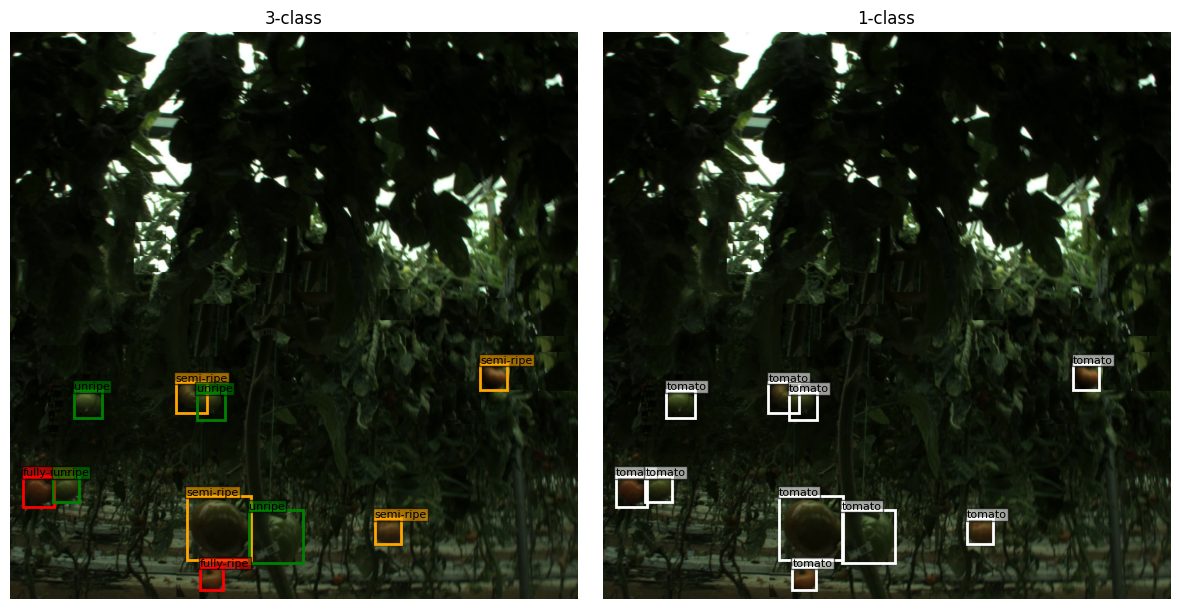

In [22]:
# 비교 대상 경로 설정
from pathlib import Path
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


TARGET_ROOT = get_project_path("data", "TomatOD_COCO_1")

images_dir = Path(TARGET_ROOT, "train", "images")
coco_3cls_json = get_project_path("data", "TomatOD_COCO_3", "train", "custom_train.json")
coco_1cls_json = get_project_path("data", "TomatOD_COCO_1", "train", "custom_train.json")

def load_coco(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    images = {img["id"]: img for img in data["images"]}
    cats = {c["id"]: c["name"] for c in data["categories"]}
    anns_by_img = {}
    for ann in data["annotations"]:
        anns_by_img.setdefault(ann["image_id"], []).append(ann)
    return images, cats, anns_by_img

imgs3, cats3, anns3 = load_coco(coco_3cls_json)
imgs1, cats1, anns1 = load_coco(coco_1cls_json)

def _pick_image_id(image_key, images):
    # image_key: 이미지 id(int) 또는 file_name(str)
    if isinstance(image_key, int):
        return image_key
    for iid, meta in images.items():
        if meta["file_name"] == image_key:
            return iid
    raise KeyError(f"{image_key} not found in annotations")

def _draw(ax, img_path, anns, cat_names, title):
    # color map by label
    color_map = {
        "tomato": "white",
        "fully-ripe": "red",
        "semi-ripe": "orange",
        "unripe": "green",
    }

    ax.imshow(Image.open(img_path).convert("RGB"))
    for ann in anns:
        x, y, w, h = ann["bbox"]
        label = cat_names.get(ann["category_id"], str(ann["category_id"]))
        edge_color = color_map.get(label, "lime")  # fallback color
        rect = patches.Rectangle((x, y), w, h, linewidth=2,
                                 edgecolor=edge_color, facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y - 2, label, color="black", fontsize=8,
                bbox=dict(facecolor=edge_color, alpha=0.6, pad=1))
    ax.set_title(title)
    ax.axis("off")


def show_comparison(image_key):
    """image_key에 이미지 id(int)나 file_name(str)을 넣으면 좌:3cls, 우:1cls 비교."""
    img_id_3 = _pick_image_id(image_key, imgs3)
    meta3 = imgs3[img_id_3]
    img_path = images_dir / meta3["file_name"]

    # 1-class 쪽에서도 같은 파일명을 찾음 (필요하면 id 직접 입력)
    img_id_1 = _pick_image_id(meta3["file_name"], imgs1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    _draw(axes[0], img_path, anns3.get(img_id_3, []), cats3, "3-class")
    _draw(axes[1], img_path, anns1.get(img_id_1, []), cats1, "1-class")
    plt.tight_layout()
    plt.show()

# 사용 예시: 이미지 id 5를 비교할 때
show_comparison(4)
# 또는 파일명으로
# show_comparison("000123.jpg")



## Ground Truth 시각화 이미지 저장

In [13]:
# 비교 대상 경로 설정
from pathlib import Path
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


TARGET_ROOT = get_project_path("data", "TomatOD_COCO_1")

images_dir = Path(TARGET_ROOT, "train", "images")
coco_3cls_json = get_project_path("data", "TomatOD_COCO_3", "train", "custom_train.json")

def load_coco(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    images = {img["id"]: img for img in data["images"]}
    cats = {c["id"]: c["name"] for c in data["categories"]}
    anns_by_img = {}
    for ann in data["annotations"]:
        anns_by_img.setdefault(ann["image_id"], []).append(ann)
    return images, cats, anns_by_img

imgs3, cats3, anns3 = load_coco(coco_3cls_json)

def _pick_image_id(image_key, images):
    # image_key: 이미지 id(int) 또는 file_name(str)
    if isinstance(image_key, int):
        return image_key
    for iid, meta in images.items():
        if meta["file_name"] == image_key:
            return iid
    raise KeyError(f"{image_key} not found in annotations")

def _draw(ax, img_path, anns, cat_names, title):
    # color map by label
    color_map = {
        "tomato": "white",
        "fully-ripe": "red",
        "semi-ripe": "orange",
        "unripe": "green",
    }

    ax.imshow(Image.open(img_path).convert("RGB"))
    for ann in anns:
        x, y, w, h = ann["bbox"]
        label = cat_names.get(ann["category_id"], str(ann["category_id"]))
        edge_color = color_map.get(label, "lime")  # fallback color
        rect = patches.Rectangle((x, y), w, h, linewidth=2,
                                 edgecolor=edge_color, facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y - 2, label, color="black", fontsize=8,
                bbox=dict(facecolor=edge_color, alpha=0.6, pad=1))
    ax.set_title(title)
    ax.axis("off")


def show_comparison(image_key):
    """image_key에 이미지 id(int)나 file_name(str)을 넣으면 좌:3cls, 우:1cls 비교."""
    img_id_3 = _pick_image_id(image_key, imgs3)
    meta3 = imgs3[img_id_3]
    img_path = images_dir / meta3["file_name"]

    # 1-class 쪽에서도 같은 파일명을 찾음 (필요하면 id 직접 입력)
    img_id_1 = _pick_image_id(meta3["file_name"], imgs1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    _draw(axes[0], img_path, anns3.get(img_id_3, []), cats3, "3-class")
    _draw(axes[1], img_path, anns1.get(img_id_1, []), cats1, "1-class")
    plt.tight_layout()
    plt.show()

# 사용 예시: 이미지 id 5를 비교할 때
show_comparison(4)
# 또는 파일명으로
# show_comparison("000123.jpg")



NameError: name 'imgs1' is not defined

In [14]:
# COCO_1 데이터 로드
coco1_path = get_project_path("data", "TomatOD_COCO_3")
coco1_train_path = os.path.join(coco1_path, "train")
coco1_val_path = os.path.join(coco1_path, "val")
coco1_test_path = os.path.join(coco1_path, "test")

coco1_images = []
coco1_annotations = []
coco1_categories = []

coco1_splits = {
    'train': coco1_train_path,
    'val': coco1_val_path,
    'test': coco1_test_path
}

for split_name, split_path in coco1_splits.items():
    json_file = os.path.join(split_path, f"custom_{split_name}.json")
    if os.path.exists(json_file):
        try:
            with open(json_file, 'r') as f:
                coco_data = json.load(f)
            
            for img in coco_data['images']:
                img['split'] = split_name
                coco1_images.append(img)
            
            for ann in coco_data['annotations']:
                ann['split'] = split_name
                coco1_annotations.append(ann)
            
            if not coco1_categories:
                coco1_categories = coco_data['categories']
            
            print(f"COCO_1 {split_name}: 이미지 {len([img for img in coco_data['images']])}개, 어노테이션 {len(coco_data['annotations'])}개")
        except Exception as e:
            print(f"COCO_1 {split_name}: 로드 오류 - {e}")

print(f"\n총 이미지: {len(coco1_images)}개")
print(f"총 어노테이션: {len(coco1_annotations)}개")
print(f"카테고리: {[cat['name'] for cat in coco1_categories]}")

COCO_1 train: 이미지 193개, 어노테이션 1937개
COCO_1 val: 이미지 54개, 어노테이션 581개
COCO_1 test: 이미지 30개, 어노테이션 279개

총 이미지: 277개
총 어노테이션: 2797개
카테고리: ['fully-ripe', 'semi-ripe', 'unripe']


In [26]:
# labels 폴더에서 GT 어노테이션 읽기 (간단 버전)

def load_annotations_from_labels_file(image_file_path, labels_dir, img_width=2000, img_height=2000):
    """
    이미지 파일 경로를 받아서 같은 이름의 labels 파일에서 어노테이션 읽기
    
    Args:
        image_file_path: 이미지 파일 경로
        labels_dir: labels 폴더 경로
        img_width: 이미지 너비 (기본값 2000)
        img_height: 이미지 높이 (기본값 2000)
    
    Returns:
        COCO 형식 어노테이션 리스트
    """
    # 이미지 파일명에서 라벨 파일명 생성
    file_name = os.path.basename(image_file_path)
    label_file_name = os.path.splitext(file_name)[0] + '.txt'
    label_file_path = os.path.join(labels_dir, label_file_name)
    
    if not os.path.exists(label_file_path):
        return []
    
    annotations = []
    with open(label_file_path, 'r') as f:
        for line_idx, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            
            try:
                parts = line.split()
                if len(parts) != 5:
                    continue
                
                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width_norm = float(parts[3])
                height_norm = float(parts[4])
                
                # YOLO 형식 → COCO 형식 변환
                x = (center_x - width_norm / 2) * img_width
                y = (center_y - height_norm / 2) * img_height
                w = width_norm * img_width
                h = height_norm * img_height
                
                ann = {
                    'category_id': class_id,
                    'bbox': [x, y, w, h],
                    'area': w * h,
                    'iscrowd': 0
                }
                annotations.append(ann)
                
            except (ValueError, IndexError) as e:
                continue
    
    return annotations


# GT bbox 시각화 함수 (labels 폴더 사용)

def visualize_gt_bboxes_from_labels(image_path, labels_dir, categories, save_path=None):
    """
    labels 폴더의 YOLO 라벨 파일에서 GT bbox를 읽어 파란색으로 시각화
    
    Args:
        image_path: 이미지 파일 경로
        labels_dir: labels 폴더 경로
        categories: 카테고리 정보 리스트
        save_path: 저장할 경로 (None이면 화면에만 표시)
    
    Returns:
        저장된 파일 경로 (save_path가 제공된 경우)
    """
    # 이미지 경로 확인
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return None
    
    # 이미지 로드
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    # labels 폴더에서 어노테이션 읽기
    annotations = load_annotations_from_labels_file(image_path, labels_dir, img_width, img_height)
    
    if not annotations:
        print(f"No annotations found in labels folder for {os.path.basename(image_path)}")
        return None
    
    # 시각화
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(img)
    ax.axis('off')
    
    # 여백 제거
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # bbox 그리기 (파란색) - 클래스 라벨 없이
    bbox_color = 'blue'
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = bbox
        
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=4,
            edgecolor=bbox_color,
            facecolor='none'
        )
        ax.add_patch(rect)
    
    # 저장 또는 표시
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', pad_inches=0)
        plt.close()
        return save_path
    else:
        plt.show()
        return None

In [27]:
# Test 데이터 시각화 - labels 폴더에서 읽기

# 경로 설정
test_images_dir = get_project_path("data", "TomatOD_YOLO_3", "test", "images")
labels_dir = get_project_path("data", "TomatOD_YOLO_3", "test", "labels")
output_dir = get_project_path("data", "TomatOD_GT_Test")
ensure_dir(output_dir)

# test 이미지 파일 목록
test_image_files = [f for f in os.listdir(test_images_dir) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Test 이미지: {len(test_image_files)}개")
print(f"Labels 폴더: {labels_dir}")
print(f"저장 경로: {output_dir}\n")

# 모든 test 이미지 시각화 및 저장
saved_count = 0
for img_file in test_image_files:
    img_path = os.path.join(test_images_dir, img_file)
    
    # 저장 파일명 생성
    base_name = os.path.splitext(img_file)[0]
    save_path = os.path.join(output_dir, f"{base_name}_gt_vis.png")
    
    # labels 폴더에서 어노테이션 읽어서 시각화 및 저장
    result = visualize_gt_bboxes_from_labels(
        image_path=img_path,
        labels_dir=labels_dir,
        categories=coco1_categories,
        save_path=save_path
    )
    
    if result:
        annotations = load_annotations_from_labels_file(img_path, labels_dir)
        saved_count += 1
        if saved_count <= 5:  # 처음 5개만 출력
            print(f"[{saved_count}/{len(test_image_files)}] 저장 완료: {os.path.basename(save_path)} (Bboxes: {len(annotations)}개)")

print(f"\n총 {saved_count}개 이미지 저장 완료: {output_dir}")

Test 이미지: 30개
Labels 폴더: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_YOLO_3/test/labels
저장 경로: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_GT_Test

[1/30] 저장 완료: stereo20190405_133623_p2_snap_012_gt_vis.png (Bboxes: 9개)
[2/30] 저장 완료: stereo20190405_133623_p2_snap_017_gt_vis.png (Bboxes: 20개)
[3/30] 저장 완료: stereo20190405_133623_p2_snap_041_gt_vis.png (Bboxes: 14개)
[4/30] 저장 완료: stereo20190405_133623_p2_snap_088_gt_vis.png (Bboxes: 11개)
[5/30] 저장 완료: stereo20190406_065607_p0_snap_362_gt_vis.png (Bboxes: 10개)

총 30개 이미지 저장 완료: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_GT_Test


In [19]:
# 단일 이미지 테스트
test_images_dir = get_project_path("data", "TomatOD_COCO_3", "test", "images")
labels_dir = get_project_path("data", "TomatOD_COCO_3", "test", "labels")

# 첫 번째 이미지로 테스트
test_image_files = [f for f in os.listdir(test_images_dir) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if test_image_files:
    test_img_path = os.path.join(test_images_dir, test_image_files[0])
    print(f"테스트 이미지: {test_image_files[0]}")
    
    # labels에서 어노테이션 읽기
    annotations = load_annotations_from_labels_file(test_img_path, labels_dir)
    print(f"어노테이션 개수: {len(annotations)}개")
    
    # 시각화
    visualize_gt_bboxes_from_labels(
        image_path=test_img_path,
        labels_dir=labels_dir,
        categories=coco1_categories
    )

테스트 이미지: stereo20190405_133623_p2_snap_012.jpg
어노테이션 개수: 0개
No annotations found in labels folder for stereo20190405_133623_p2_snap_012.jpg


### json으로 annotation

In [30]:
# Test 데이터 시각화 - COCO JSON에서 읽기

from pathlib import Path
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 경로 설정
test_images_dir = get_project_path("data", "TomatOD_COCO_3", "test", "images")
coco_test_json = get_project_path("data", "TomatOD_COCO_3", "test", "custom_test.json")
output_dir = get_project_path("data", "TomatOD_GT_Test_JSON")
ensure_dir(output_dir)

# COCO JSON 로드
def load_coco(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    images = {img["id"]: img for img in data["images"]}
    cats = {c["id"]: c["name"] for c in data["categories"]}
    anns_by_img = {}
    for ann in data["annotations"]:
        anns_by_img.setdefault(ann["image_id"], []).append(ann)
    return images, cats, anns_by_img

# JSON 로드
imgs, cats, anns_by_img = load_coco(coco_test_json)

print(f"Test 이미지: {len(imgs)}개")
print(f"카테고리: {list(cats.values())}")
print(f"저장 경로: {output_dir}\n")

# 색상 맵
color_map = {
    "tomato": "blue",
    "fully-ripe": "red",
    "semi-ripe": "orange",
    "unripe": "green",
}

# 모든 test 이미지 시각화 및 저장
saved_count = 0
for img_id, img_info in imgs.items():
    file_name = img_info["file_name"]
    img_path = os.path.join(test_images_dir, file_name)
    
    if not os.path.exists(img_path):
        print(f"이미지 파일 없음: {img_path}")
        continue
    
    # 해당 이미지의 어노테이션 가져오기
    annotations = anns_by_img.get(img_id, [])
    
    # 이미지 로드
    img = Image.open(img_path).convert("RGB")
    
    # 시각화
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(img)
    ax.axis('off')
    
    # 여백 제거
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # bbox 그리기
    for ann in annotations:
        x, y, w, h = ann["bbox"]  # COCO 형식: [x, y, width, height]
        category_id = ann["category_id"]
        label = cats.get(category_id, f"class_{category_id}")
        edge_color = color_map.get(label, "blue")
        
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=4,
            edgecolor=edge_color,
            facecolor='none'
        )
        ax.add_patch(rect)
    
    # 저장 파일명 생성
    base_name = os.path.splitext(file_name)[0]
    save_path = os.path.join(output_dir, f"{base_name}_gt_vis.png")
    
    # 저장
    plt.savefig(save_path, dpi=150, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    saved_count += 1
    if saved_count <= 5:  # 처음 5개만 출력
        print(f"[{saved_count}/{len(imgs)}] 저장 완료: {os.path.basename(save_path)} (Bboxes: {len(annotations)}개)")

print(f"\n총 {saved_count}개 이미지 저장 완료: {output_dir}")

Test 이미지: 30개
카테고리: ['fully-ripe', 'semi-ripe', 'unripe']
저장 경로: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_GT_Test_JSON

[1/30] 저장 완료: stereo20190406_054921_p0_snap_299_gt_vis.png (Bboxes: 3개)
[2/30] 저장 완료: stereo20190405_135104_p0_snap_034_gt_vis.png (Bboxes: 8개)
[3/30] 저장 완료: stereo20190406_065607_p0_snap_383_gt_vis.png (Bboxes: 4개)
[4/30] 저장 완료: stereo20190406_065607_p0_snap_137_gt_vis.png (Bboxes: 14개)
[5/30] 저장 완료: stereo20190405_133623_p2_snap_017_gt_vis.png (Bboxes: 20개)

총 30개 이미지 저장 완료: /home/hyeonjin/tomato-detection-agentic/data/TomatOD_GT_Test_JSON
